In [1]:
import pandas as pd
import itertools
import collections
import numpy as np
from tqdm import tqdm
import gensim
import re
import json
import sklearn
import matplotlib.pyplot as plt

We import a csv file with issues and lists of queries for those issues, created by experts.
We also load a fasttext word embedding model

In [2]:
filename_issues = '/home/dafne/shared/FilterBubble/issue-positions/issues-queries.csv'
filename_fasttext = '/home/dafne/shared/FilterBubble/word-embeddings/fasttext-aem-amcat50.bin'

In [3]:
model = gensim.models.fasttext.load_facebook_model(filename_fasttext)

In [4]:
df_issues = pd.read_csv(filename_issues)
df_issues.head()

,queryIssue,directI,parentI,gparentI,parentA,gparentA,zoek1,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,aardgasbaten,pos,begrotingssaldo,issue,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ambtenarensal*,neg,begrotingssaldo,issue,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,begrotingsdiscipline,pos,begrotingssaldo,issue,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,begrotingsnorm,pos,begrotingssaldo,issue,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,begrotingsoverschot,pos,begrotingssaldo,issue,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We are only interested in the `queryIssue` column and `parentI` column. `dircetI` might be interesting in the future because it tells something about directionality, but we ignore it for now.

We need to do some cleaning up: there's a spelling mistake for one issue.

In [13]:
df_issues.loc[df_issues.parentI=='infrastructuur', 'parentI'] = 'Infrastructuur'

These are the number of queries per issue:

In [14]:
df_issues.parentI.value_counts()

klimaatMilieu          112
ondernemingsklimaat     71
Infrastructuur          70
ontwikkelingCrim        66
coronabestrijding       65
OenW                    65
geZorg                  61
socZek                  56
belastHeffing           53
bestrijdingCrim         45
integratie              35
vrijheidsrechten        29
werk                    25
coronaverspreiding      25
EuropeseUnie            24
normenWaarden           22
begrotingssaldo         20
woning                  18
terreurbestrijding      14
bestVernieuw            13
ontwikHulp              12
Name: parentI, dtype: int64

In [15]:
issues_dict = df_issues.groupby('parentI')['queryIssue'].agg(list).to_dict()

## Expand queries with wild cards
Some query words contain asterices for pattern matching. We expand the query set to include all words from the embedding vocabulary that match the pattenrs

In [11]:
# Retrieve vocabulary of embedding model
vocab = model.wv.vocab.keys()
len(vocab)

1143658

In [16]:
issues_dict_expanded = collections.defaultdict(list)

for issue, query_list in issues_dict.items():
    print(issue)
    for query_term in query_list:
        if '*' in query_term:
            query_regex = re.compile(query_term.replace('*', '.*'))
            new_queries = [(v, 'expanded') for v in vocab if query_regex.fullmatch(v) ]
            issues_dict_expanded[issue].extend(new_queries)
            issues_dict_expanded[issue].append((query_term, 'wildcard'))
        else:
            issues_dict_expanded[issue].append((query_term, 'original'))

EuropeseUnie
Infrastructuur
OenW
begrotingssaldo
belastHeffing
bestVernieuw
bestrijdingCrim
coronabestrijding
coronaverspreiding
geZorg
integratie
klimaatMilieu
normenWaarden
ondernemingsklimaat
ontwikHulp
ontwikkelingCrim
socZek
terreurbestrijding
vrijheidsrechten
werk
woning


In [17]:
# And put them in a dataframe
issues_expanded_df = pd.DataFrame([(query, issue, category) for issue, query_list in issues_dict_expanded.items() for (query, category) in query_list],
             columns=('query', 'issue', 'category'))
issues_expanded_df.head()

,query,issue,category
0,3 procent,EuropeseUnie,original
1,60 procent,EuropeseUnie,original
2,brexit,EuropeseUnie,original
3,coronaherstelfonds,EuropeseUnie,original
4,ECB,EuropeseUnie,original


Let's have a look at the number of queries in the original set (not containing a wildcard), the number of wildcard queries and the number of queries that result from the expansion.

Note that the expansion leads to a much bigger set than the original query set!

In [18]:
issues_expanded_df.groupby(['issue', 'category']).count().unstack()

query                  
category            expanded original wildcard
issue                                         
EuropeseUnie              12       21        3
Infrastructuur          5056       39       31
OenW                    3766       31       34
begrotingssaldo          206       15        5
belastHeffing            504       41       12
bestVernieuw              87       11        2
bestrijdingCrim          604       32       13
coronabestrijding        583       40       25
coronaverspreiding       267       18        7
geZorg                  3717       29       32
integratie              1425       16       19
klimaatMilieu            853       70       42
normenWaarden            727       12       10
ondernemingsklimaat     2706       35       36
ontwikHulp                65        8        4
ontwikkelingCrim        2527       33       33
socZek                  1673       37       19
terreurbestrijding       757        7        7
vrijheidsrechten         574       23        6
werk                    1387       17        8
woning                    53       10        8

We also check for each of the queries, whether the query exists in the fasttext vocabulary. For wildcard queries, we remove the asterix and see if the remaining string exists.
Note that some queries consist of multiple words, these will not be found in the vocabulary.

In [21]:
in_vocab_list = []
for _, (query, issue, category) in issues_expanded_df.iterrows():
    if category == 'original':
        in_vocab = query in vocab
    elif category == 'wildcard':
        in_vocab = query.replace('*','') in vocab
    else:
        in_vocab = True
        
    in_vocab_list.append(in_vocab)

issues_expanded_df['vocab'] = in_vocab_list

How many of the words can be found in the vocabulary?

In [35]:
counts_per_cat = issues_expanded_df.groupby(['category', 'vocab'])['query'].count().unstack().fillna(0)
counts_per_cat['percentage'] = counts_per_cat[True] / (counts_per_cat[False]+counts_per_cat[True])
counts_per_cat

vocab,False,True,percentage
category,,,
expanded,0.0,27549.0,1.000000
original,127.0,418.0,0.766972
wildcard,88.0,268.0,0.752809


And plot the number of query terms (without the expansion) for each issue. Note that some issues, like EuropeseUnie and ontwikHulp have very few query words with many out-of-vocabulary.

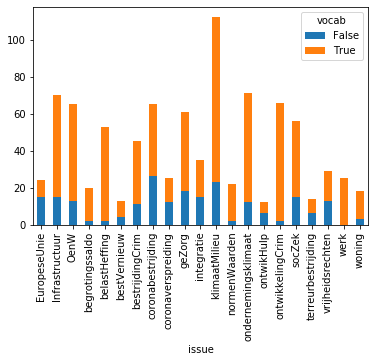

In [29]:
issues_expanded_df[issues_expanded_df.category!='expanded'].groupby(['issue', 'vocab'])['query'].count().unstack().plot(kind='bar', stacked=True)

There's also some query words that are present in multiple issues

In [41]:
query_counts = issues_expanded_df['query'].value_counts()
double_queries = query_counts[query_counts>1].index
double_queries = issues_expanded_df[issues_expanded_df['query'].isin(double_queries)]
double_queries

,query,issue,category,vocab
32,medicijnagentschap,EuropeseUnie,original,True
290,filebelasting,Infrastructuur,expanded,True
809,havenbelasting,Infrastructuur,expanded,True
1181,parkeerbelasting,Infrastructuur,expanded,True
3401,transportbelasting,Infrastructuur,expanded,True
...,...,...,...,...
27940,arbeidertje,werk,expanded,True
27941,arbeiderstuinen,werk,expanded,True
27943,arbeidsuren,werk,original,True
28239,werknemersverzekeringen,werk,expanded,True


Most result from the expanded query sets, if we look at the non-expanded queries there is no overlap:

In [49]:
double_queries[double_queries['category']!='expanded'].sort_values('query')

,query,issue,category,vocab
27943,arbeidsuren,werk,original,True
9671,belasting,belastHeffing,original,True
26475,discriminatieverbod,vrijheidsrechten,original,True
9711,dividendbelasting,belastHeffing,original,True
9718,inkomensbelasting,belastHeffing,original,True
9723,loonbelasting,belastHeffing,original,True
32,medicijnagentschap,EuropeseUnie,original,True
19421,omzetverlies,ondernemingsklimaat,original,True
19588,ondernemingsklimaat,ondernemingsklimaat,original,True
26749,persvrijheid,vrijheidsrechten,original,True


In [45]:
double_queries_lists = double_queries.groupby(['query'])['issue'].agg(list)
multiple_queries = pd.DataFrame(double_queries_lists.to_list(), columns=['issue1', 'issue2'], index=double_queries_lists.index)

In [47]:
# Compare which issues often have overlap
multiple_queries.reset_index().groupby(['issue1', 'issue2']).count().unstack()

query                                         \
issue2              belastHeffing coronabestrijding geZorg klimaatMilieu   
issue1                                                                     
EuropeseUnie                  NaN               NaN    1.0           NaN   
Infrastructuur                6.0               NaN    NaN           NaN   
OenW                          2.0               NaN    NaN           NaN   
belastHeffing                 6.0               NaN    2.0           1.0   
coronabestrijding             NaN               1.0    NaN           NaN   
geZorg                        NaN               NaN    NaN           NaN   
integratie                    NaN               NaN    NaN           NaN   
normenWaarden                 NaN               NaN    NaN           NaN   
ondernemingsklimaat           NaN               NaN    NaN           NaN   
ontwikkelingCrim              NaN               NaN    NaN           NaN   
socZek                        NaN               NaN    NaN           NaN   
vrijheidsrechten              NaN               NaN    NaN           NaN   
werk                          NaN               NaN    NaN           NaN   

                                                                               \
issue2              normenWaarden ondernemingsklimaat ontwikkelingCrim socZek   
issue1                                                                          
EuropeseUnie                  NaN                 NaN              NaN    NaN   
Infrastructuur                NaN                 NaN              NaN    NaN   
OenW                          NaN                 NaN              NaN    NaN   
belastHeffing                 NaN                 6.0              NaN    1.0   
coronabestrijding             NaN                 NaN              NaN    NaN   
geZorg                        NaN                 7.0              NaN    1.0   
integratie                    8.0                 NaN              NaN    NaN   
normenWaarden                 NaN                 NaN              NaN    NaN   
ondernemingsklimaat           NaN                 2.0              NaN    NaN   
ontwikkelingCrim              NaN                 NaN              5.0  213.0   
socZek                        NaN                 NaN              NaN    NaN   
vrijheidsrechten              NaN                 NaN              NaN    NaN   
werk                          NaN                 NaN              NaN    NaN   

                                                                
issue2              terreurbestrijding vrijheidsrechten   werk  
issue1                                                          
EuropeseUnie                       NaN              NaN    NaN  
Infrastructuur                     NaN              NaN    NaN  
OenW                               NaN              3.0    NaN  
belastHeffing                      1.0              NaN    1.0  
coronabestrijding                  NaN              NaN    NaN  
geZorg                             NaN              NaN    NaN  
integratie                         NaN              1.0    NaN  
normenWaarden                      NaN              1.0    NaN  
ondernemingsklimaat                NaN              2.0    NaN  
ontwikkelingCrim                   NaN              NaN    NaN  
socZek                             NaN              1.0  167.0  
vrijheidsrechten                   NaN              1.0    NaN  
werk                               NaN              NaN    1.0

## Write a file with the query terms

In [37]:
issues_expanded_df.to_csv('/home/dafne/shared/FilterBubble/issue-positions/queries-asterix-expanded.csv')